In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import time

from pathlib import Path
from sklearn import metrics
import random
from scipy import stats

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision

from datetime import datetime
from collections import OrderedDict

In [2]:
import pickle

In [3]:
PATH = Path("../../multi-task-romain/data/")
#PATH = Path("/home/menyssa/Recherche/Mimic-III-Yannet/Data/Yannet/data/")

In [4]:
gap = "10min"
gap

'10min'

In [5]:
filename = "data_train_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    train = pickle.load(f)

In [6]:
filename = "data_valid_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    valid = pickle.load(f)

In [7]:
train.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
0,10013,10013_16,1,87,49,7,2,1,0,1,95.44,55.88,"[[99.9, 94.2, 107.3, 36.2, 56.7], [107.2, 94.8...",0
1,10013,10013_17,1,87,49,7,2,1,0,1,83.92,70.28,"[[96.0, 92.0, 106.2, 35.2, 55.9], [101.9, 92.7...",0
2,10013,10013_18,1,87,49,7,2,1,0,1,100.14,65.08,"[[0.0, 94.7, 128.5, 43.5, 69.9], [0.0, 94.7, 1...",0
3,10013,10013_21,1,87,49,7,2,1,0,1,102.86,70.6,"[[99.3, 92.0, 126.3, 50.5, 75.6], [100.6, 91.7...",0
4,10013,10013_22,1,87,49,7,2,1,0,1,109.3,61.86,"[[100.7, 93.9, 113.0, 41.6, 66.6], [100.1, 94....",0


In [8]:
valid.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
1154,11018,11018_26,0,67,47,1,0,0,0,0,74.3533,71.8733,"[[79.0, 97.0, 99.0, 60.0, 71.0], [79.0, 97.0, ...",1
1155,11018,11018_28,0,67,47,1,0,0,0,0,81.33,78.9333,"[[77.0, 97.0, 103.0, 62.0, 75.0], [76.0, 96.0,...",1
1156,11018,11018_29,0,67,47,1,0,0,0,0,81.2033,79.9233,"[[83.0, 95.0, 111.0, 65.0, 80.0], [84.0, 95.0,...",1
1157,11018,11018_30,0,67,47,1,0,0,0,0,81.3867,83.5367,"[[81.0, 95.0, 114.0, 65.0, 81.0], [81.0, 94.0,...",1
1158,11018,11018_31,0,67,47,1,0,0,0,0,78.67,84.5967,"[[84.0, 95.0, 114.0, 67.0, 81.0], [81.0, 94.0,...",1


In [9]:
train.shape, valid.shape

((50255, 14), (5926, 14))

In [10]:
subject_id_list = np.sort(np.unique(train.subject_id.values))
id2index = {v: k+1 for k,v in enumerate(subject_id_list)}
num_subjects = len(subject_id_list)

In [11]:
# Number of subjects in training
num_subjects

2203

## Dataset

In [12]:
def get_mean_std_series(train):
    ss = np.concatenate(train.series.values)
    ss = ss.reshape(-1,5)
    return ss.mean(axis=0), ss.std(axis=0)

In [13]:
def get_mean_std_static(train):
    res = {}
    for name in ["age", "sapsii", "sofa"]:
        values = train[name].values
        res[name] = (values.mean(), values.std())
    res["series"] = get_mean_std_series(train)
    return res

In [14]:
norm_dict = get_mean_std_static(train)
norm_dict 

{'age': (64, 15.057877220725963),
 'sapsii': (33, 14.224363336863284),
 'sofa': (4, 3.7706540212497375),
 'series': (array([ 83.2305084 ,  93.6846448 , 120.9199471 ,  58.75308973,
          78.5877452 ]),
  array([16.09288223, 17.43347146, 21.26444372, 12.27698671, 14.32744073]))}

In [15]:
class MultiTask(Dataset):
    def __init__(self, df, norm_dict, id2index, k=20, train=True):
        """
        Args:
            df: dataframe with data
            norm_dict: mean and std of all variables to normalize
            
        """
        self.norm_dict = norm_dict
        self.df = df
        self.names = ["age", "sapsii", "sofa"] ## needs normalization
        self.names_binary = ["gender", "amine", "sedation", "ventilation"]
        self.id2index = id2index
        self.train = train
        self.df_sample = self.pick_a_sample(k)
            
    def pick_a_sample(self, k=20):
        """ Picks sample with the same number of observations per patient"""
        if not self.train: # fix seed for validation and test
            np.random.seed(3)
        sample = self.df.groupby("subject_id", group_keys=False).apply(lambda x: x.sample(min(len(x), k)))
        sample = sample.copy()
        if self.train:
            self.subject_index = [self.id2index[subject_id] for subject_id in sample.subject_id.values]
            self.random = np.random.choice(2, sample.shape[0], p=[0.1, 0.9])
            self.subject_index = self.subject_index*self.random
        return sample

    def __getitem__(self, index):
        row = self.df_sample.iloc[index,:]
        x_series = (row.series - self.norm_dict["series"][0])/self.norm_dict["series"][1]
        x_cont = [(row[name]-self.norm_dict[name][0])/self.norm_dict[name][1] for name in self.names]
        x_binary = [row[name] for name in self.names_binary]
        subject_index = 0
        if self.train:
            subject_index = self.subject_index[index]
        x_cat = np.array([row["care_unit"], subject_index])
        x_cont = np.array(x_cont + x_binary)
        return x_series, x_cont, x_cat, row["prediction_mean_HR"], row["prediction_mean_MAP"]

    def __len__(self):
        return self.df_sample.shape[0]

In [16]:
train_ds = MultiTask(train, norm_dict, id2index, train = True)
valid_ds = MultiTask(valid, norm_dict, id2index, train = False)

In [17]:
print(len(train_ds), len(valid_ds))

27108 3180


In [18]:
x1, x2, x3, y1, y2 = train_ds[1200]
x1, x2, x3, y1, y2

(array([[-0.13238824,  0.35078241,  1.01013942, -0.24868396,  0.35681563],
        [-0.20074144,  0.3622546 ,  1.09008508, -0.24868396,  0.41963215],
        [-0.20074144,  0.30489368,  0.87846422, -0.23239332,  0.30795834],
        [-0.15724395,  0.27621322,  0.96311256, -0.19981204,  0.34983602],
        [-0.18831359,  0.26474103,  0.92078839, -0.28941057,  0.27306027],
        [-0.18209966,  0.2131162 ,  1.0524636 , -0.19981204,  0.35681563],
        [-0.20074144,  0.19590792,  1.02424748, -0.15094011,  0.41963215],
        [-0.11996039,  0.19017183,  0.73738364, -0.45231699,  0.02877379],
        [-0.23181108,  0.19017183,  0.68095141, -0.42788103,  0.04273302],
        [-0.18209966,  0.19017183,  0.72327558, -0.31384653,  0.16836606],
        [-0.20695537,  0.17296356,  0.64332992, -0.35457314,  0.0846107 ],
        [-0.16345788,  0.15575528,  0.79851856, -0.26497461,  0.21024375],
        [-0.20074144,  0.16722746,  1.20765223,  0.11785549,  0.67089824],
        [-0.18209966,  0.

In [19]:
tab = train.groupby(['care_unit']).size()
tab

care_unit
0     7373
1    17077
2    11899
3     9358
4     4548
dtype: int64

## Model

In [20]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [21]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [22]:
class EventModel1(nn.Module):
    def __init__(self, hidden_size=100):
        super(EventModel1, self).__init__()
        self.embedding1 = nn.Embedding(5, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 10 + 1 + 5
        self.linear1 = nn.Linear(7, 10)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(10)

    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x_cont = self.bn1(F.relu(self.linear1(x_cont))) 
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        return self.out1(x), self.out2(x)

In [23]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat1 = []
    ys1 = []
    y_hat2 = []
    ys2 = []
    for x_series, x_cont, x_cat, y1, y2 in valid_dl:
        batch = y1.shape[0]
        x_series = x_series.float()
        x_cont = x_cont.float()
        x_cat = x_cat.long()
        y1 = y1.float()
        y2 = y2.float()
        out1, out2 = model(x_series, x_cont, x_cat)
        mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
        mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
        loss = mse_loss1 + mse_loss2
        sum_loss += batch*(loss.item())
        total += batch
        y_hat1.append(out1.view(-1).detach().numpy())
        ys1.append(y1.view(-1).numpy())
        y_hat2.append(out2.view(-1).detach().numpy())
        ys2.append(y2.view(-1).numpy())
    
    y_hat1 = np.concatenate(y_hat1)
    y_hat2 = np.concatenate(y_hat2)
    ys1 = np.concatenate(ys1)
    ys2 = np.concatenate(ys2)
    r2_1, p, lo2_1, hi2_1 =  pearsonr_ci(ys1, y_hat1, alpha=0.05)
    r2_2, p, lo2_2, hi2_2 =  pearsonr_ci(ys2, y_hat2, alpha=0.05)
    #r2_1 = metrics.r2_score(ys1, y_hat1)
    #r2_2 = metrics.r2_score(ys2, y_hat2)
    #return sum_loss/total,
    return sum_loss/total,  r2_1,lo2_1, hi2_1, r2_2, lo2_2, hi2_2

In [24]:
def train_epochs(model, train_ds, optimizer, filename, lr=1e-3, epochs = 30):
    t = time.process_time()
    prev_val_r2 = 0
    for i in range(epochs):
        sum_loss1 = 0
        sum_loss2 = 0
        total = 0
        train_ds.pick_a_sample()
        train_dl = DataLoader(train_ds, batch_size=5000, shuffle=True)
        valid_dl = DataLoader(valid_ds, batch_size=batch_size)
        for x_series, x_cont, x_cat, y1, y2 in train_dl:
            model.train()
            x_series = x_series.float()
            x_cont = x_cont.float()
            x_cat = x_cat.long()
            y1 = y1.float()
            y2 = y2.float()
            out1, out2 = model(x_series, x_cont, x_cat)
            mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
            mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
            loss = mse_loss1 + mse_loss2
            sum_loss1 += len(y1) * mse_loss1.item()
            sum_loss2 += len(y1) * mse_loss2.item()
            total += len(y1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 1 == 0:
            print("iteration : ", i)
            # val_loss, val_r2_1, val_r2_2 = val_metrics(model, valid_dl)
            #train_loss, train_r2_1,  train_lo2_1,  train_hi2_1, train_r2_2,  train_lo2_2,  train_hi2_2  = val_metrics(model, train_dl)
            #print("\tTrain loss (after): {:.3f}".format(train_loss)) 
            print("\tTrain loss: {:.3f} {:.3f}".format(sum_loss1/total, sum_loss2/total))             
            val_loss, val_r2_1,  val_lo2_1,  val_hi2_1, val_r2_2,  val_lo2_2,  val_hi2_2  = val_metrics(model, valid_dl)
            print("\tValid loss: {:.3f} \n valid r2 hr {:.3f}[{:.3f}-{:.3f}] valid r2 map {:.3f}[{:.3f}-{:.3f}]".format(
               val_loss, val_r2_1,  val_lo2_1,  val_hi2_1, val_r2_2,  val_lo2_2,  val_hi2_2))
            
        if val_r2_1 > prev_val_r2:
            prev_val_r2 = val_r2_1
            if val_r2_1 > 0.95:
                PATH = Path("../../multi-task-romain/2e_analyse/multitask/")
                path = "{0}/{1}_10min_r2_{2:.0f}_{3:.0f}.pth".format(PATH, filename, 100*val_r2_1, 100*val_r2_2) 
                save_model(model, path)
                print(path)
    elapsed_time = time.process_time() - t
    print('time consuming: ', elapsed_time, 'secs')

In [25]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [26]:
model = EventModel1()

In [27]:
val_metrics(model, valid_dl)

(13631.47265625,
 0.50953686,
 0.4833384056258305,
 0.5348234209543314,
 -0.021439211,
 -0.056156141178210175,
 0.0133294989884983)

In [28]:
# 0s in training
model = EventModel1()

optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="multi_model", epochs=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer,filename="multi_model", epochs=15)

iteration :  0
	Train loss: 6122.944 5370.005
	Valid loss: 7534.920 
 valid r2 hr 0.318[0.287-0.349] valid r2 map 0.669[0.649-0.687]
iteration :  1
	Train loss: 3047.762 2574.728
	Valid loss: 2404.703 
 valid r2 hr 0.305[0.273-0.336] valid r2 map 0.491[0.465-0.517]
iteration :  2
	Train loss: 852.340 635.615
	Valid loss: 338.732 
 valid r2 hr 0.530[0.505-0.555] valid r2 map 0.553[0.528-0.577]
iteration :  3
	Train loss: 200.154 172.545
	Valid loss: 894.749 
 valid r2 hr 0.741[0.725-0.756] valid r2 map 0.765[0.750-0.779]
iteration :  4
	Train loss: 303.312 273.518
	Valid loss: 648.896 
 valid r2 hr 0.795[0.782-0.808] valid r2 map 0.846[0.836-0.856]
iteration :  5
	Train loss: 151.932 107.622
	Valid loss: 149.684 
 valid r2 hr 0.849[0.839-0.858] valid r2 map 0.846[0.836-0.856]
iteration :  6
	Train loss: 68.966 60.610
	Valid loss: 109.976 
 valid r2 hr 0.896[0.888-0.902] valid r2 map 0.852[0.842-0.861]
iteration :  7
	Train loss: 55.328 63.572
	Valid loss: 96.974 
 valid r2 hr 0.905[0.89

## Calibration plot

In [29]:
file = Path("../../multi-task-romain/2e_analyse/multitask/multi_model_10min_r2_97_94.pth")
model = EventModel1()
load_model(model, file)

In [30]:
filename = "data_test_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    test = pickle.load(f)
    
filename = "data_validation_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    test_larib = pickle.load(f)
test_larib["care_unit"] = 4
test.shape, test_larib.shape

((7002, 14), (1314, 13))

In [31]:
def predict_one_batch(model, dl):
    for x_series, x_cont, x_cat, y1, y2 in dl:
        x_series = x_series.float()
        x_cont = x_cont.float()
        x_cat = x_cat.long()
        y1 = y1.float()
        y2 = y2.float()
        out1, out2 = model(x_series, x_cont, x_cat)
    return out1.detach().numpy(), out2.detach().numpy(), y1.detach().numpy(), y2.detach().numpy()

class MultiTask_validation(Dataset):
    def __init__(self, df, norm_dict, id2index, k=20, train=True):
        """
        Args:
            df: dataframe with data
            norm_dict: mean and std of all variables to normalize
            
        """
        self.norm_dict = norm_dict
        self.df = df
        self.names = ["age", "sapsii", "sofa"] ## needs normalization
        self.names_binary = ["gender", "amine", "sedation", "ventilation"]
        self.id2index = id2index
        self.train = train
        self.df_sample = self.pick_a_sample(k)
            
    def pick_a_sample(self, k=20):
        """ Picks sample with the same number of observations per patient"""
        if not self.train: # fix seed for validation and test
            np.random.seed(3)
# We don't want the same number of period per patient
        # sample = self.df.groupby("subject_id", group_keys=False).apply(lambda x: x.sample(k, replace=True))
        sample = self.df.copy()
        if self.train:
# 10 percent of the periods have a subject_index == 0
            self.subject_index = [self.id2index[subject_id] for subject_id in sample.subject_id.values]
            self.random = np.random.choice(2, sample.shape[0], p = [0.1, 0.9])
            self.subject_index = self.subject_index*self.random
        return sample

    def __getitem__(self, index):
        row = self.df_sample.iloc[index,:] 
        x_series = (row.series - self.norm_dict["series"][0])/self.norm_dict["series"][1]
        x_cont = [(row[name]-self.norm_dict[name][0])/self.norm_dict[name][1] for name in self.names]
        x_binary = [row[name] for name in self.names_binary]
        subject_index = 0
        if self.train:
            subject_index = self.subject_index[index]
        x_cat = np.array([row["care_unit"], subject_index])
        x_cont = np.array(x_cont + x_binary)
        return x_series, x_cont, x_cat, row["prediction_mean_HR"], row["prediction_mean_MAP"]

    def __len__(self):
        return self.df_sample.shape[0]

In [32]:
test_ds = MultiTask_validation(test, norm_dict, id2index, train = False)
test_dl = DataLoader(test_ds, batch_size=8233)

In [33]:
norm_dict_valid = get_mean_std_static(test_larib)
test_larib_ds = MultiTask_validation(test_larib, norm_dict, id2index, train = False)
# test_larib_ds = MultiTask(test_larib, norm_dict, id2index, train = False)
test_larib_dl = DataLoader(test_larib_ds, batch_size=1597)

In [34]:
val_metrics(model, test_dl)

(41.63927459716797,
 0.9689801,
 0.9675161938160327,
 0.970378964754301,
 0.9418818,
 0.9391786021856441,
 0.9444682551584032)

In [35]:
val_metrics(model, test_larib_dl)

(129.95477294921875,
 0.9157407,
 0.9065566567622231,
 0.924058092040123,
 0.89177823,
 0.8801457064436012,
 0.9023403892498338)

### Mimic III testing set predictions

In [36]:
out1, out2, y1, y2 = predict_one_batch(model, test_dl)
y1 = np.reshape(y1, (-1,1))
y2 = np.reshape(y2, (-1,1))
arr_hr = np.concatenate((out1, y1) , axis=1)
arr_map = np.concatenate((out2, y2) , axis=1)
pd.DataFrame(arr_hr).to_csv("/home/menyssa/Recherche/Mimic-III-Yannet/resultats/2e_analyse/intern_obs_pred_HR_10.csv")
pd.DataFrame(arr_map).to_csv("/home/menyssa/Recherche/Mimic-III-Yannet/resultats/2e_analyse/intern_obs_pred_MAP_10.csv")

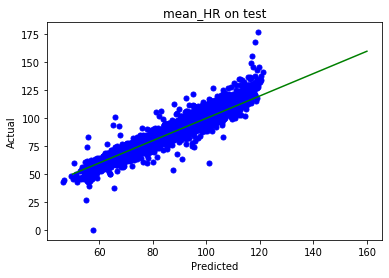

In [37]:
x = np.linspace(50, 160, 1000)
plt.plot(out1, y1, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_HR on test")
plt.plot(x, x, '-g')
plt.show()

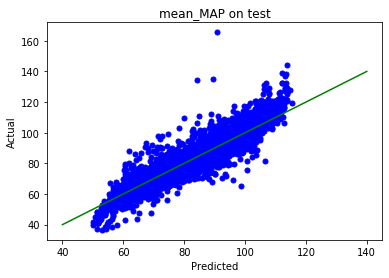

In [38]:
x = np.linspace(40, 140, 1000)
plt.plot(out2, y2, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_MAP on test")
plt.plot(x, x, '-g')
plt.show()

### Lariboisiere predictions

In [39]:
out1, out2, y1, y2 = predict_one_batch(model, test_larib_dl)

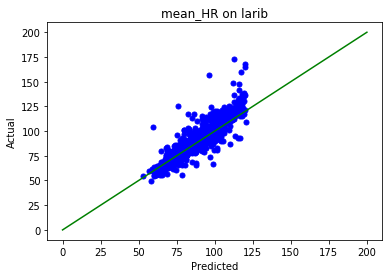

In [40]:
x = np.linspace(0, 200, 1000)
plt.plot(out1, y1, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_HR on larib")
plt.plot(x, x, '-g')
plt.show()

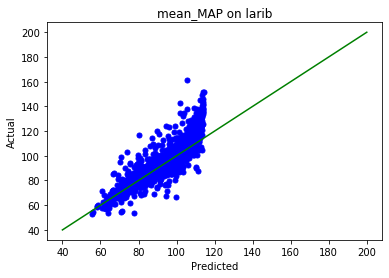

In [41]:
x = np.linspace(40, 200, 1000)
plt.plot(out2, y2, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_MAP on larib")
plt.plot(x, x, '-g')
plt.show()

In [42]:
y1 = np.reshape(y1, (-1,1))
y2 = np.reshape(y2, (-1,1))
arr_hr = np.concatenate((out1, y1) , axis=1)
arr_map = np.concatenate((out2, y2) , axis=1)
periode = np.reshape(test_larib.key.values, (-1,1))
arr_hr = np.concatenate((out1, y1, periode) , axis=1)
arr_map = np.concatenate((out2, y2, periode) , axis=1)
pd.DataFrame(arr_hr).to_csv("/home/menyssa/Recherche/Mimic-III-Yannet/resultats/2e_analyse/larib_obs_pred_HR_10.csv")
pd.DataFrame(arr_map).to_csv("/home/menyssa/Recherche/Mimic-III-Yannet/resultats/2e_analyse/larib_obs_pred_MAP_10.csv")